In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [4]:
!pip install kaggle

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 98% 324M/331M [00:03<00:00, 115MB/s]
100% 331M/331M [00:03<00:00, 112MB/s]


In [4]:
import zipfile

In [5]:
zip_file = '/content/utkface-new.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/utkface')

In [5]:
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
print(len(filenames))
print(filenames[:3])

23708
['35_1_3_20170104231848138.jpg.chip.jpg', '23_0_3_20170119164331517.jpg.chip.jpg', '55_0_0_20170104212750765.jpg.chip.jpg']


In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [9]:
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [10]:
df.head()

,image,age,gender,race
0,5_1_2_20161219160221254.jpg.chip.jpg,5,1,2
1,29_0_0_20170117180839466.jpg.chip.jpg,29,0,0
2,52_0_0_20170120222910474.jpg.chip.jpg,52,0,0
3,31_0_1_20170113142511604.jpg.chip.jpg,31,0,1
4,60_1_0_20170110151506029.jpg.chip.jpg,60,1,0


In [11]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [12]:
df.head()

,image,age,gender,race
0,5_1_2_20161219160221254.jpg.chip.jpg,5,1,2
1,29_0_0_20170117180839466.jpg.chip.jpg,29,0,0
2,52_0_0_20170120222910474.jpg.chip.jpg,52,0,0
3,31_0_1_20170113142511604.jpg.chip.jpg,31,0,1
4,60_1_0_20170110151506029.jpg.chip.jpg,60,1,0


In [13]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [14]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [15]:
df.head()

,image,age,gender,race
0,5_1_2_20161219160221254.jpg.chip.jpg,5,1,2
1,29_0_0_20170117180839466.jpg.chip.jpg,29,0,0
2,52_0_0_20170120222910474.jpg.chip.jpg,52,0,0
3,31_0_1_20170113142511604.jpg.chip.jpg,31,0,1
4,60_1_0_20170110151506029.jpg.chip.jpg,60,1,0


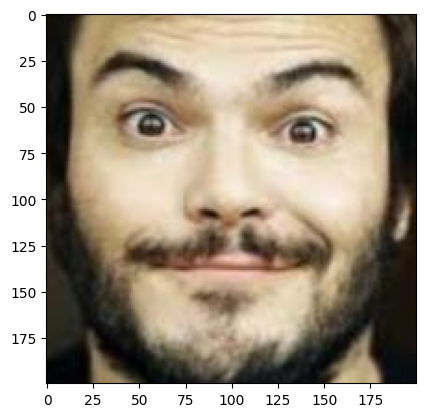

In [16]:
img = Image.open("/content/utkface/UTKFace/"+df['image'][1])
plt.imshow(img)

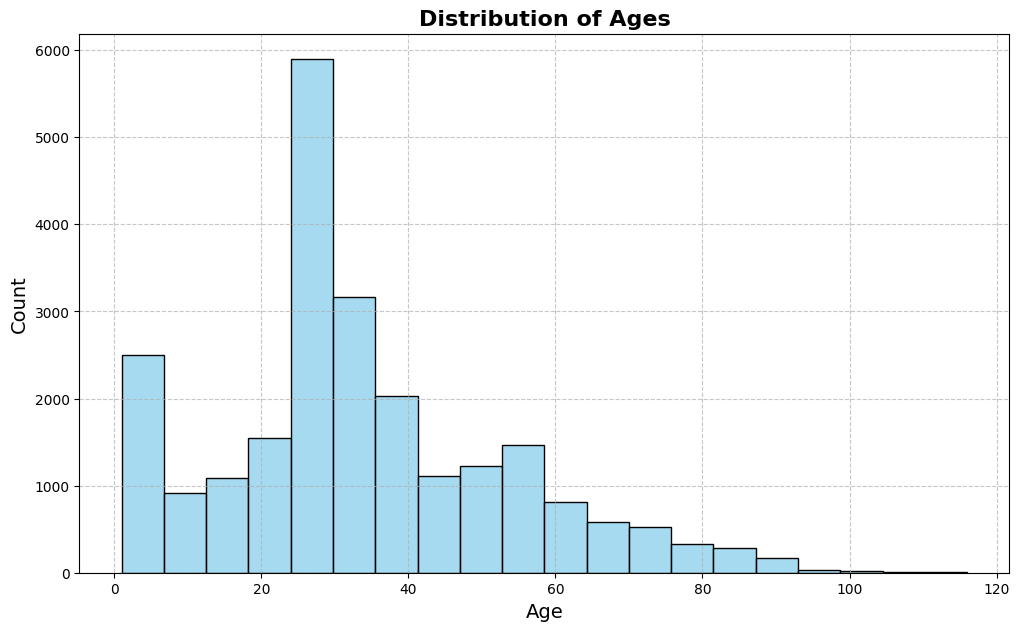

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))


sns.histplot(df['age'], bins=20, kde=False, color='skyblue', edgecolor='black')


plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()

<ipython-input-18-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

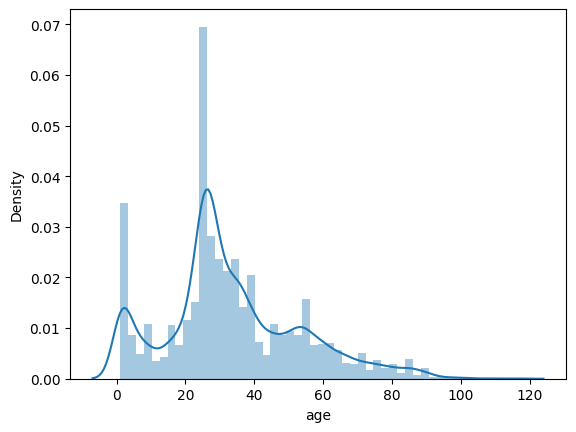

In [18]:
sns.distplot(df.age)

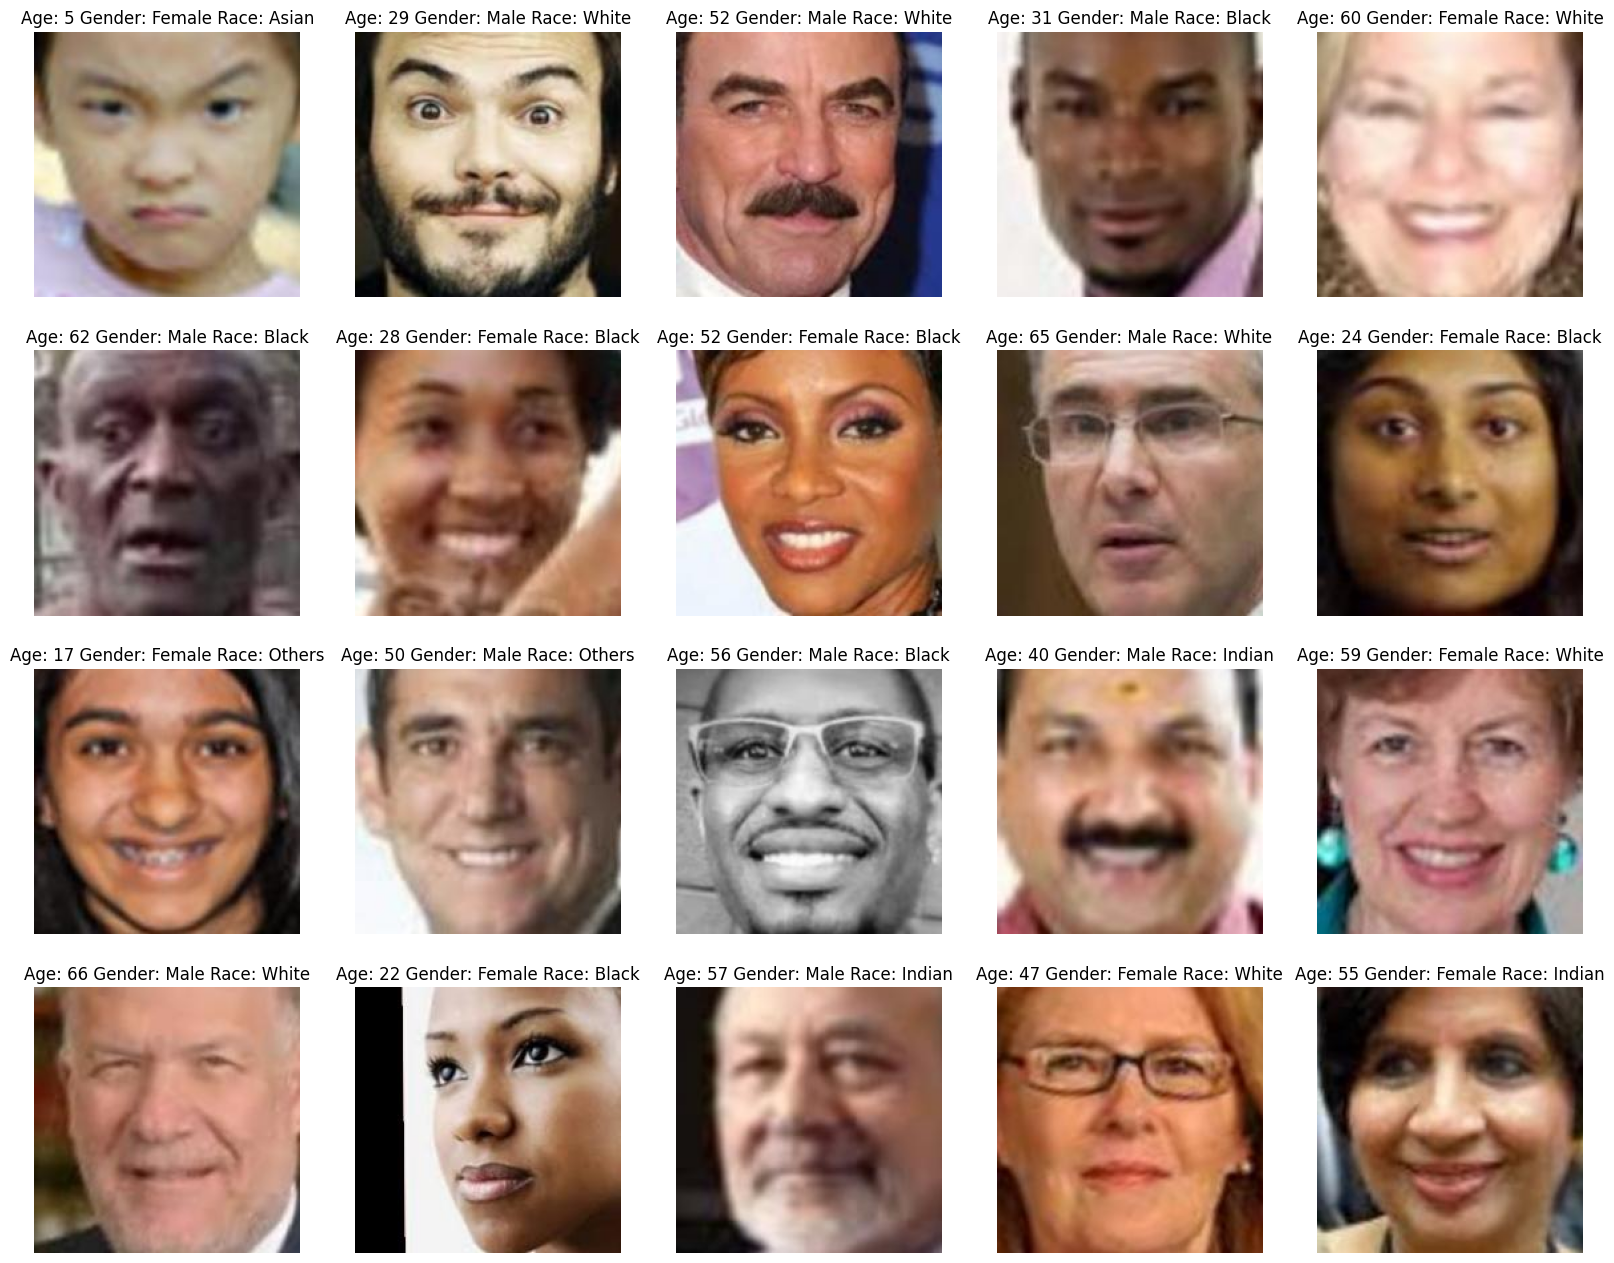

In [19]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

In [20]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [21]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [22]:
train.shape

(18964, 4)

In [23]:
test.shape

(4741, 4)

In [24]:
train.head()

,image,age,gender,race
21098,35_0_0_20170105172445389.jpg.chip.jpg,35,0,0
20881,60_0_1_20170113185141927.jpg.chip.jpg,60,0,1
21548,45_1_3_20170104234959306.jpg.chip.jpg,45,1,3
13630,32_0_0_20170116191419267.jpg.chip.jpg,32,0,0
8226,37_1_3_20170119202520478.jpg.chip.jpg,37,1,3


In [25]:
x_train = []
for file in train.image:
    img = load_img("/content/utkface/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)
x_train.shape

(18964, 224, 224, 3)

In [26]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [27]:
from tensorflow.keras.utils import to_categorical

y_race = to_categorical(y_race, num_classes=5)

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform

In [29]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply the VGG16 base model
X = conv_base(inputs)

# Flatten the output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
y_race

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_by_race_output.keras',
    monitor='val_race_output_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint]
)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 108s 167ms/step - age_output_mean_absolute_error: 38.2054 - gender_output_accuracy: 0.7805 - loss: 3499.9631 - race_output_accuracy: 0.4127 - val_age_output_mean_absolute_error: 32.0811 - val_gender_output_accuracy: 0.8777 - val_loss: 1414.0566 - val_race_output_accuracy: 0.4207
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_race_output_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


534/534 ━━━━━━━━━━━━━━━━━━━━ 114s 144ms/step - age_output_mean_absolute_error: 32.8588 - gender_output_accuracy: 0.8666 - loss: 1477.2185 - race_output_accuracy: 0.4403 - val_age_output_mean_absolute_error: 31.5880 - val_gender_output_accuracy: 0.8830 - val_loss: 1382.6172 - val_race_output_accuracy: 0.4254
Epoch 3/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - age_output_mean_absolute_error: 32.2935 - gender_output_accuracy: 0.8905 - loss: 1439.4719 - race_output_accuracy: 0.4309 - val_age_output_mean_absolute_error: 31.1220 - val_gender_output_accuracy: 0.8877 - val_loss: 1350.7307 - val_race_output_accuracy: 0.4191
Epoch 4/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 149ms/step - age_output_mean_absolute_error: 31.9112 - gender_output_accuracy: 0.9027 - loss: 1407.1279 - race_output_accuracy: 0.4284 - val_age_output_mean_absolute_error: 30.6644 - val_gender_output_accuracy: 0.8882 - val_loss: 1319.1542 - val_race_output_accuracy: 0.4702
Epoch 5/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/ste

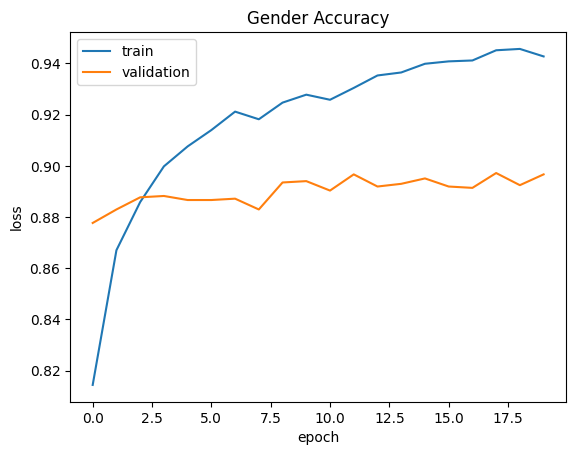

In [44]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

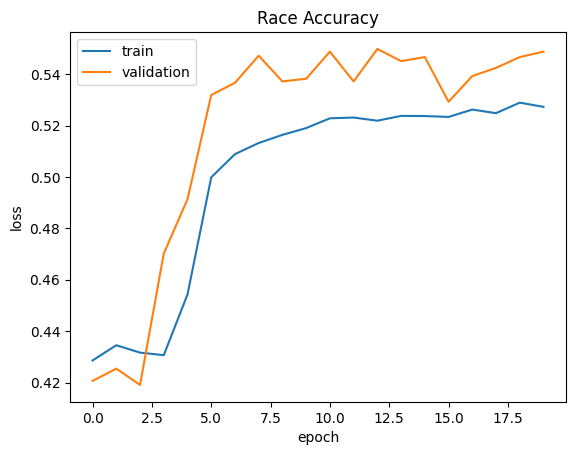

In [43]:
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('Race Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [46]:
import numpy

In [47]:
print(np.argmax(y_race[index]))

2


Original: Gender =  Female  Age =  42  Race =  White
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Gender =  Female  Age =  29  Race =  White


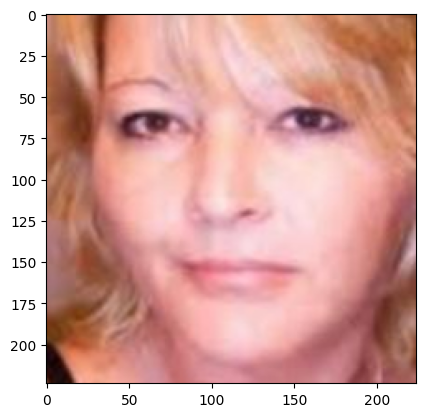

In [48]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index]," Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender," Age = ", pred_age," Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))

In [49]:
test.head()

,image,age,gender,race
17816,45_1_0_20170117145704297.jpg.chip.jpg,45,1,0
15082,8_1_0_20170109204910999.jpg.chip.jpg,8,1,0
22831,1_1_3_20161220220157201.jpg.chip.jpg,1,1,3
16076,26_1_3_20170119193143376.jpg.chip.jpg,26,1,3
8973,31_1_3_20170119200201348.jpg.chip.jpg,31,1,3


In [52]:
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [57]:
x_test = []
for file in test.image:
    img = load_img("test.jpg")

    img = img.resize((224, 224), Image.LANCZOS)
    img = np.array(img)
    x_test.append(img)

x_test = np.array(x_test)

In [58]:
test_acc = model.evaluate(x_test, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)

In [60]:
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [67]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])
print('gender accuracy:', test_acc[3])
print('age mean absolute error:', test_acc[3])
print('race accuracy:', test_acc[2])

total loss: 763.7185668945312
gender loss: 21.74631118774414
age loss: 0.4741615653038025
race loss: 0.4351402521133423
gender accuracy: 0.4351402521133423
age mean absolute error: 0.4351402521133423
race accuracy: 0.4741615653038025


In [68]:
x_test.shape

(4741, 224, 224, 3)

In [69]:
pred = model.predict(x_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


In [70]:
pred[2][0]

array([9.9083626e-01, 5.7972738e-06, 5.3308297e-05, 2.2644426e-05,
       9.0819728e-03], dtype=float32)

In [71]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [72]:
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [73]:
df_pred['gender'].value_counts()

,count
gender,
Female,4741


In [74]:
df_pred['age'].value_counts()

,count
age,
15,4741


In [75]:
df_pred['race'].value_counts()

,count
race,
White,4741
